In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [84]:
#fn: estimated is <1/4 of actual
#fp: actual is <1/4 of estimated
#fp/fn: require diff > diff_thresh to remove low expressed genes
#misassigned (delta Tx): abs(estimated - real), ie, total count difference between esitmated and real

def compute_stats(esimated, real, diff_thresh = 5):
    diff = esimated - real

    fn = []
    fp = []
    diffs = []
    fn_vals = []
    fp_vals = []
    
    for col in diff.columns:
        fp_thresh = esimated[col]//4
        fn_thresh = real[col]//4
        #fp_a = real[col] < fp_thresh
        fp_a = (real[col] < fp_thresh) & (abs(diff[col]) > diff_thresh)
        #fn_a = esimated[col] < fn_thresh
        fn_a = (esimated[col] < fn_thresh) & (abs(diff[col]) > diff_thresh)

        fn.append((fn_a[fn_a].shape[0], real[col][real[col] > 0].shape[0]))
        fp.append((fp_a[fp_a].shape[0], esimated[col][esimated[col] > 0].shape[0]))
        diffs.append((abs(diff[col]).sum().round(), real[col].sum()))


        fn_vals += real[col][fn_a].tolist()
        fp_vals += esimated[col][fp_a].tolist()

    # #fn,#real    #fp,#esimated    #misasigned reads,#total reads    all fn vals    all fp vals
    return fn, fp, diffs, #fn_vals, fp_vals

# GTEX

In [2]:
#these are the counts used to simulate the reads
########### init real counts
real_counts = pd.read_csv('gtex_500.csv', index_col = 0, usecols=range(241))
##########

In [86]:
gtex_res = {}

In [87]:
###############load gtex res
#(yes i know redundant and I prob could have made a function, but was lazy)

#######salmon
dirs = os.listdir('gtex_salmon_out/')
samples = sorted(dirs, key=lambda x: int(x.split('_')[1]))

columns = []

for sample in tqdm(samples):
    b = pd.read_csv('gtex_salmon_out/' + sample + '/quant.sf', delimiter = '\t')
    columns.append(b['NumReads'])

temp = pd.DataFrame(np.column_stack(columns),
                     columns = real_counts.columns)
temp.index = b['Name'].values
temp = temp.reindex(real_counts.index)
temp = temp.fillna(0)

gtex_res['salmon'] = temp.copy()



####load kallisto

dirs = os.listdir('gtex_kallisto_out')
samples = sorted(dirs, key=lambda x: int(x.split('_')[1]))
columns = []

for sample in tqdm(samples):
    b = pd.read_csv('gtex_kallisto_out/' + sample + '/abundance.tsv', delimiter = '\t')
    columns.append(b['est_counts'])

temp = pd.DataFrame(np.column_stack(columns),
                     columns = real_counts.columns)

temp.index = b.target_id.map(lambda x: x.split('|')[0]).values
temp = temp.reindex(real_counts.index)
temp = temp.fillna(0)

gtex_res['kallisto'] = temp.copy()



# #########stringtie


temp = pd.read_csv('gtex_stringtie/wut_if_god_was.csv')
temp = temp.set_index('transcript_id')
cols = sorted(temp.columns, key=lambda x: int(x.split('_')[1]))
temp = temp[cols]
temp = temp.reindex(real_counts.index)
temp.columns = real_counts.columns
temp = temp/2 ####stringtie doesnt account for paried reads
temp = temp.fillna(0)


gtex_res['stringtie'] = temp.copy()

#rsem
dirs = os.listdir('gtex_rsem')
dirs = [x for x in dirs if 'isoforms.results' in x]
samples = sorted(dirs, key=lambda x: int(x.split('_')[1].split('.')[0]))


columns = []

for sample in tqdm(samples):
    b = pd.read_csv('gtex_rsem/' + sample, delimiter = '\t')
    columns.append(b['expected_count'])

temp = pd.DataFrame(np.column_stack(columns),
                     columns = real_counts.columns)

temp.index = b.transcript_id
temp = temp.reindex(real_counts.index)
temp = temp.fillna(0)
gtex_res['rsem'] = temp.copy()

100%|█████████████████████████████████████████| 240/240 [01:10<00:00,  3.42it/s]


In [91]:
fns = []
fps = []
misassigned = []
#fn_vals_df = []
#fp_vals_df = []

for item in gtex_res:
    fn, fp, diffs  = compute_stats(gtex_res[item], real_counts, diff_thresh = 5) 

    temp = pd.DataFrame(fn, columns = ['num_fn', 'total_txs'])
    temp['percent_fn'] = temp.num_fn/temp.total_txs * 100
    temp['method'] = item
    fns.append(temp)

    temp = pd.DataFrame(fp, columns = ['num_fp', 'total_txs'])
    temp['percent_fp'] = temp.num_fp/temp.total_txs * 100
    temp['method'] = item
    fps.append(temp)

    temp = pd.DataFrame(diffs, columns = ['num_misassigned', 'total_reads'])
    temp['percent_misassigned'] = temp.num_misassigned/temp.total_reads * 100
    temp['method'] = item
    misassigned.append(temp)

    # temp = pd.DataFrame(fn_vals, columns = ['fn_vals'])
    # temp['method'] = item
    # fn_vals_df.append(temp)

    # temp = pd.DataFrame(fp_vals, columns = ['fp_vals'])
    # temp['method'] = item
    # fp_vals_df.append(temp)


In [92]:
fns = pd.concat(fns)
fps = pd.concat(fps)
misassigned = pd.concat(misassigned)
#fn_vals_df = pd.concat(fn_vals_df)
#fp_vals_df = pd.concat(fp_vals_df)

In [123]:
!mkdir figures

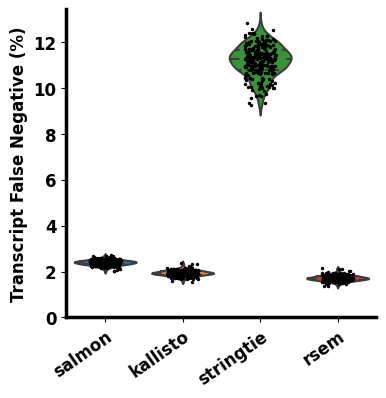

In [125]:
plt.figure(figsize = (4,4))

ax = sns.violinplot(data = fns, x = 'method', y = 'percent_fn', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = fns, x = 'method', y = 'percent_fn', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel('Transcript False Negative (%)', size = 12, weight = 'bold')

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/tx_fn.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_fn.svg', bbox_inches = 'tight')

plt.show()

In [10]:
fns.groupby('method').median().sort_values('percent_fn')

,num_fn,total_txs,percent_fn
method,,,
rsem,1260.5,73337.0,1.715967
kallisto,1416.5,73337.0,1.933294
salmon,1771.0,73337.0,2.404956
stringtie,8222.0,73337.0,11.267077


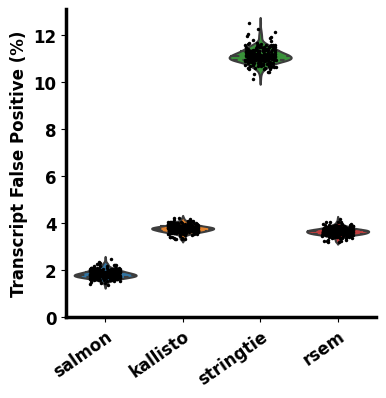

In [126]:
# ax = sns.violinplot(data = fps, x = 'method', y = 'percent_fp', inner = 'quartile')
# ax = sns.stripplot(data = fps, x = 'method', y = 'percent_fp', s = 3, c = 'k')

# plt.ylim(bottom = 0)

# plt.show()



plt.figure(figsize = (4,4))

ax = sns.violinplot(data = fps, x = 'method', y = 'percent_fp', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = fps, x = 'method', y = 'percent_fp', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel('Transcript False Positive (%)', size = 12, weight = 'bold')

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/tx_fp.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_fp.svg', bbox_inches = 'tight')



plt.show()

In [13]:
fps.groupby('method').median().sort_values('percent_fp')

,num_fp,total_txs,percent_fp
method,,,
salmon,1274.5,70129.0,1.823324
rsem,2813.5,76135.5,3.655441
kallisto,2945.5,77427.5,3.778042
stringtie,9688.0,87413.5,11.093454


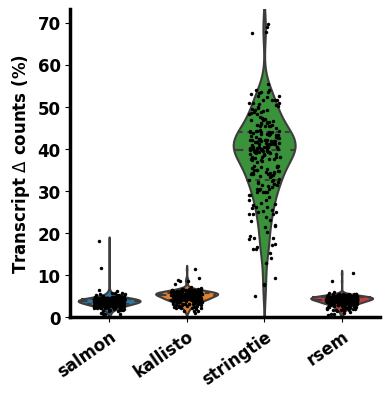

In [127]:
# ax = sns.violinplot(data = misassigned, x = 'method', y = 'percent_misassigned', inner = 'quartile')
# ax = sns.stripplot(data = misassigned, x = 'method', y = 'percent_misassigned', s = 3, c = 'k')

# plt.ylim(bottom = 0)

# plt.show()


plt.figure(figsize = (4,4))

ax = sns.violinplot(data = misassigned, x = 'method', y = 'percent_misassigned', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = misassigned, x = 'method', y = 'percent_misassigned', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel(r'Transcript $\Delta$ counts (%)', size=12, weight='bold')


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/tx_delta.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_delta.svg', bbox_inches = 'tight')


plt.show()

In [15]:
misassigned.groupby('method').median().sort_values('percent_misassigned')

,num_misassigned,total_reads,percent_misassigned
method,,,
salmon,592263.5,16572190.0,3.788257
rsem,656891.0,16572190.0,4.256962
kallisto,813836.0,16572190.0,5.240656
stringtie,6205623.0,16572190.0,39.867254


# GTEX GENES

Same as above but compressing into genes instead of transcripts and including featurecounts and htseq

In [128]:
#dict of gene names and transcripts
tx2gene = pd.read_csv('tx2gene.csv', usecols=[1,2])
tx2gene = dict(zip(tx2gene.tx_id, tx2gene.gene_id))

#make a tx df into a gene df
def genefy(df):
    xyz = df.copy()
    xyz['gene'] = xyz.index.map(lambda x: x.split('.')[0]).map(tx2gene)
    xyz = xyz.groupby('gene').sum()
    return xyz




In [129]:
gene_counts = genefy(real_counts)

In [130]:
gene_counts

,GTEX-111CU-2026-SM-5GZZC,GTEX-111VG-2226-SM-5N9DU,GTEX-1128S-2326-SM-5GZZY,GTEX-113IC-0226-SM-5HL5C,GTEX-117YX-1226-SM-5H11S,GTEX-11DXW-1226-SM-5H133,GTEX-11DXX-1926-SM-5EGJK,GTEX-11DXX-2326-SM-9YFKS,GTEX-11DXZ-0726-SM-5N9C4,GTEX-11DXZ-2626-SM-59882,...,GTEX-1GPI7-0326-SM-7MKH6,GTEX-1GPI7-0926-SM-7PC3J,GTEX-1GTWX-0426-SM-9MQM1,GTEX-1GZ2Q-0226-SM-7P8TL,GTEX-1GZ4H-0126-SM-9JGGI,GTEX-1GZ4I-0011-R4a-SM-9QEI9,GTEX-1H1CY-0011-R5a-SM-CM2SN,GTEX-1H1CY-3026-SM-9OSW7,GTEX-1H1DG-0011-R10b-SM-CE6S7,GTEX-1H1ZS-0526-SM-9WG5L
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,14.0,81.0,78.0,120.0,61.0,1140.0,54.0,155.0,42.0,56.0,...,139.0,167.0,722.0,37.0,60.0,57.0,86.0,14.0,93.0,280.0
ENSG00000000005,0.0,1.0,11.0,7.0,0.0,0.0,5.0,20.0,0.0,0.0,...,0.0,72.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,156.0
ENSG00000000419,68.0,63.0,98.0,20.0,106.0,40.0,49.0,106.0,65.0,35.0,...,59.0,67.0,110.0,44.0,30.0,7.0,88.0,80.0,82.0,104.0
ENSG00000000457,492.0,156.0,273.0,178.0,321.0,196.0,288.0,431.0,283.0,170.0,...,424.0,428.0,282.0,443.0,237.0,35.0,85.0,207.0,149.0,415.0
ENSG00000000460,68.0,126.0,171.0,184.0,10.0,207.0,203.0,68.0,250.0,107.0,...,228.0,258.0,245.0,123.0,96.0,45.0,49.0,253.0,75.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000291313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000291314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000291315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
#convert earlier tx data to gene data
gtex_genes = {}
for item in gtex_res:
    gtex_genes[item] = genefy(gtex_res[item])

In [132]:
#feature counts import
b = pd.read_csv('gtex_feature_counts.txt', delimiter = '\t', skiprows=1)
b = b.drop(columns = ['Chr', 'Start', 'End', 'Strand', 'Length']).set_index('Geneid')
b.columns = b.columns.map(lambda x: x.split('/')[1].split('A')[0])
samples = sorted(b.columns, key=lambda x: int(x.split('_')[1]))
b = b[samples]
b.index = b.index.map(lambda x: x.split('.')[0])
b = b.reindex(gene_counts.index)
b.columns = gene_counts.columns
b = b.fillna(0)

gtex_genes['featureCounts'] = b

In [133]:
#htseq import
files = os.listdir('htseq_gtex_counts/')
samples = sorted(files, key=lambda x: int(x.split('_')[2].split('.')[0]))

columns = []
for sample in tqdm(samples):
    b = pd.read_csv('htseq_gtex_counts/' + sample, delimiter = '\t', header = None)
    b = b.set_index(0)
    columns.append(b[1])

temp = pd.DataFrame(np.column_stack(columns),
                     columns = gene_counts.columns)
temp.index = b.index.values

temp.index = temp.index.map(lambda x: x.split('.')[0])

temp = temp.reindex(gene_counts.index)
temp = temp.fillna(0)

gtex_genes['HTseq'] = temp

100%|█████████████████████████████████████████| 240/240 [00:08<00:00, 27.55it/s]


In [134]:
fns = []
fps = []
misassigned = []
# fn_vals_df = []
# fp_vals_df = []

for item in gtex_genes:
    fn, fp, diffs = compute_stats(gtex_genes[item], gene_counts, diff_thresh = 5)

    temp = pd.DataFrame(fn, columns = ['num_fn', 'total_txs'])
    temp['percent_fn'] = temp.num_fn/temp.total_txs * 100
    temp['method'] = item
    fns.append(temp)

    temp = pd.DataFrame(fp, columns = ['num_fp', 'total_txs'])
    temp['percent_fp'] = temp.num_fp/temp.total_txs * 100
    temp['method'] = item
    fps.append(temp)

    temp = pd.DataFrame(diffs, columns = ['num_misassigned', 'total_reads'])
    temp['percent_misassigned'] = temp.num_misassigned/temp.total_reads * 100
    temp['method'] = item
    misassigned.append(temp)

    # temp = pd.DataFrame(fn_vals, columns = ['fn_vals'])
    # temp['method'] = item
    # fn_vals_df.append(temp)

    # temp = pd.DataFrame(fp_vals, columns = ['fp_vals'])
    # temp['method'] = item
    # fp_vals_df.append(temp)


In [135]:
fns = pd.concat(fns)
fps = pd.concat(fps)
misassigned = pd.concat(misassigned)
# fn_vals_df = pd.concat(fn_vals_df)
# fp_vals_df = pd.concat(fp_vals_df)

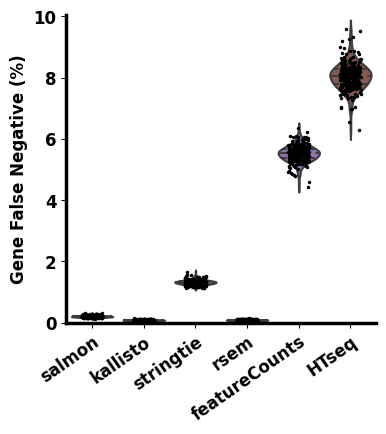

In [136]:


plt.figure(figsize = (4,4))

ax = sns.violinplot(data = fns, x = 'method', y = 'percent_fn', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = fns, x = 'method', y = 'percent_fn', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel('Gene False Negative (%)', size = 12, weight = 'bold')

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/ge_fn.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/ge_fn.svg', bbox_inches = 'tight')

plt.show()

In [25]:
fns.groupby('method').median().sort_values('percent_fn')

,num_fn,total_txs,percent_fn
method,,,
kallisto,18.0,24071.0,0.076917
rsem,20.0,24071.0,0.081798
salmon,47.5,24071.0,0.198717
stringtie,314.0,24071.0,1.312401
featureCounts,1318.0,24071.0,5.532086
HTseq,1925.0,24071.0,8.047310


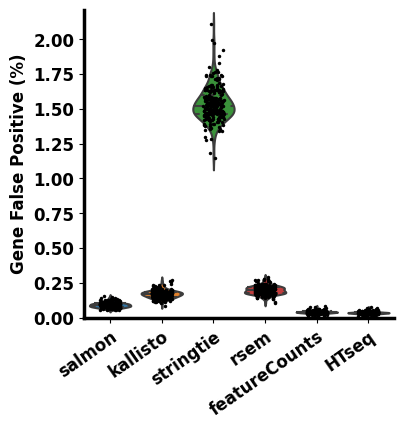

In [137]:


plt.figure(figsize = (4,4))

ax = sns.violinplot(data = fps, x = 'method', y = 'percent_fp', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = fps, x = 'method', y = 'percent_fp', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel('Gene False Positive (%)', size = 12, weight = 'bold')

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/ge_fp.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/ge_fp.svg', bbox_inches = 'tight')

plt.show()

In [27]:
fps.groupby('method').median().sort_values('percent_fp')

,num_fp,total_txs,percent_fp
method,,,
HTseq,8.0,21765.0,0.034768
featureCounts,9.0,22658.0,0.038939
salmon,21.0,23916.5,0.090265
kallisto,40.0,24125.0,0.168736
rsem,47.0,24168.0,0.195434
stringtie,371.0,24353.5,1.522543


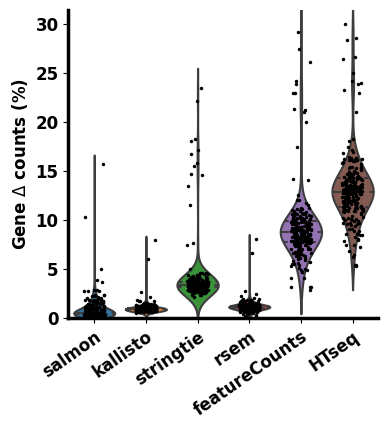

In [138]:



plt.figure(figsize = (4,4))

ax = sns.violinplot(data = misassigned, x = 'method', y = 'percent_misassigned', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = misassigned, x = 'method', y = 'percent_misassigned', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel(r'Gene $\Delta$ counts (%)', size=12, weight='bold')


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/ge_delta.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/ge_delta.svg', bbox_inches = 'tight')


plt.show()

In [29]:
misassigned.groupby('method').median().sort_values('percent_misassigned')

,num_misassigned,total_reads,percent_misassigned
method,,,
salmon,67426.0,16572190.0,0.432117
kallisto,140742.5,16572190.0,0.849870
rsem,169288.5,16572190.0,1.092831
stringtie,563654.5,16572190.0,3.340119
featureCounts,1433247.5,16572190.0,8.693570
HTseq,2116352.0,16572190.0,12.868565


# Effects DE?

In [139]:
#taken from pyDeseq2
from typing import Tuple, Union

def deseq2_norm(
    counts: Union[pd.DataFrame, np.ndarray]
) -> Tuple[Union[pd.DataFrame, np.ndarray], Union[pd.DataFrame, np.ndarray]]:
    """
    Return normalized counts

    Uses the median of ratios method.

    Parameters
    ----------
    counts : pandas.DataFrame or ndarray
            Raw counts. One column per gene, one row per sample.

    Returns
    -------
    deseq2_counts : pandas.DataFrame or ndarray
        DESeq2 normalized counts.
        One column per gene, rows are indexed by sample barcodes.

    """
    counts = counts.T

    # Compute gene-wise mean log counts
    with np.errstate(divide="ignore"):  # ignore division by zero warnings
        log_counts = np.log(counts)
    logmeans = log_counts.mean(0)
    # Filter out genes with -∞ log means
    filtered_genes = ~np.isinf(logmeans)
    # Subtract filtered log means from log counts
    if isinstance(log_counts, pd.DataFrame):
        log_ratios = log_counts.loc[:, filtered_genes] - logmeans[filtered_genes]
    else:
        log_ratios = log_counts[:, filtered_genes] - logmeans[filtered_genes]
    # Compute sample-wise median of log ratios
    log_medians = np.median(log_ratios, axis=1)
    # Return raw counts divided by size factors (exponential of log ratios)
    # and size factors
    size_factors = np.exp(log_medians)
    deseq2_counts = counts / size_factors[:, None]
    return deseq2_counts.T #, size_factors




def ratio_bonanza(df):
    
    a = df[df.columns[0]] + 1
    
    result_dict = {}
    # Iterate over all columns except the first one
    for col in df.columns[1:]:
        b = df[col] + 1
        c = a / b
        d = -b / a
        c[c < 1] = 0
        d[d >= -1] = 0

        new_col = c + d

        #log2 it
        new_col = np.sign(new_col) * np.log2(np.abs(new_col) + 1)
        
        result_dict[col] = new_col
        
    result_df = pd.DataFrame(result_dict)
        
    return result_df



def delta_ratio(esimated, real, esimated_counts, real_counts, thresh = 10):
    diff = esimated - real
    diffs = []
    
    for col in diff.columns:
        mask_a = real_counts[col] > thresh #if either real or estimated above thresh
        mask_b = real_counts[col] > thresh
        mask = mask_a | mask_b
        
        diffs.append(abs(diff[col][mask]).sum().round())

    return diffs

In [140]:
real_ratios = ratio_bonanza(deseq2_norm(real_counts))

In [141]:
delta_ratios = []
for item in gtex_res:
    temp = ratio_bonanza(deseq2_norm(gtex_res[item]))
    a = pd.DataFrame(delta_ratio(temp, real_ratios, gtex_res[item], real_counts, thresh = 10), columns = ['delta_ratio'])
    a['method'] = item
    delta_ratios.append(a)

delta_ratios = pd.concat(delta_ratios)


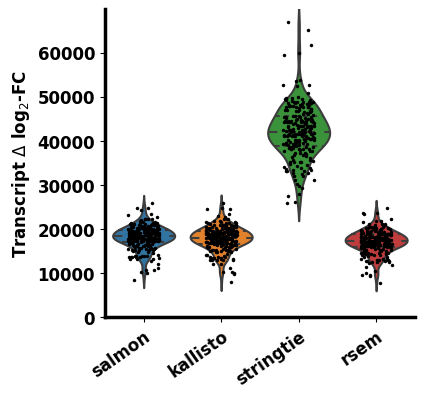

In [145]:


plt.figure(figsize = (4,4))

ax = sns.violinplot(data = delta_ratios, x = 'method', y = 'delta_ratio', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = delta_ratios, x = 'method', y = 'delta_ratio', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel(r'Transcript $\Delta$ log$_2$-FC', size=12, weight='bold')


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/tx_lfc.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_lfc.svg', bbox_inches = 'tight')


plt.show()

In [148]:
real_ratios = ratio_bonanza(deseq2_norm(gene_counts))
delta_ratios = []
for item in gtex_genes:
    temp = ratio_bonanza(deseq2_norm(gtex_genes[item]))
    a = pd.DataFrame(delta_ratio(temp, real_ratios, gtex_genes[item], gene_counts, thresh = 10), columns = ['delta_ratio'])
    a['method'] = item
    delta_ratios.append(a)

delta_ratios = pd.concat(delta_ratios)


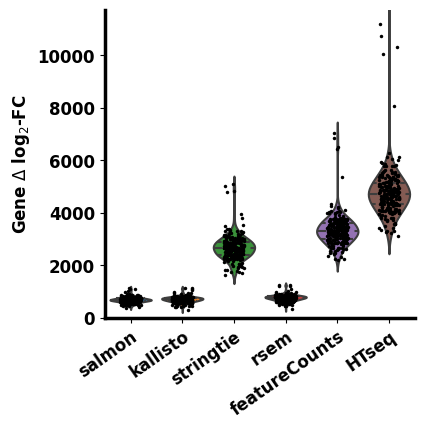

In [149]:
plt.figure(figsize = (4,4))

ax = sns.violinplot(data = delta_ratios, x = 'method', y = 'delta_ratio', inner = 'quartile', scale = 'width')
ax = sns.stripplot(data = delta_ratios, x = 'method', y = 'delta_ratio', s = 2.5, c = 'k', jitter = 0.2)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel(r'Gene $\Delta$ log$_2$-FC', size=12, weight='bold')


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.savefig('figures/ge_lfc.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/ge_lfc.svg', bbox_inches = 'tight')


plt.show()

# Increasing depth

I took 5 samples with similar overal counts. I simulated those samples at depths from 1% to 100%.

In [3]:
#similar to earlier but extract the percent value from each sample
def compute_stats(esimated, real, diff_thresh = 5):
    diff = esimated - real

    fn = []
    fp = []
    diffs = []
    
    for col in diff.columns:
        per = int(col.split('_')[0].replace('p',''))
        
        fp_thresh = esimated[col]//4
        fn_thresh = real[col]//4
        #fp_a = real[col] < fp_thresh
        fp_a = (real[col] < fp_thresh) & (abs(diff[col]) > diff_thresh)
        #fn_a = esimated[col] < fn_thresh
        fn_a = (esimated[col] < fn_thresh) & (abs(diff[col]) > diff_thresh)

        fn.append((per, fn_a[fn_a].shape[0], real[col][real[col] > 0].shape[0]))
        fp.append((per, fp_a[fp_a].shape[0], esimated[col][esimated[col] > 0].shape[0]))
        diffs.append((per, abs(diff[col]).sum().round(), real[col].sum()))



    # #fn,#real    #fp,#esimated    #missasigned reads,#total reads  
    return fn, fp, diffs

In [4]:
sampers = []
for per in [1,5,10,15,20,25,30,40,50,60,70,80,90,100]:
    for x in range(1,6):
        sampers.append('p' + str(per) + '_' + str(x))

In [5]:
#counts used to generate the reads with polyester
real_increasing = pd.read_csv('increasing_depth.csv')
real_increasing.index = real_counts.index
real_increasing.columns = sampers

In [6]:
real_increasing

,p1_1,p1_2,p1_3,p1_4,p1_5,p5_1,p5_2,p5_3,p5_4,p5_5,...,p90_1,p90_2,p90_3,p90_4,p90_5,p100_1,p100_2,p100_3,p100_4,p100_5
transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000456328.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
ENST00000450305.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000488147.1,7.0,0.0,1.0,3.0,5.0,37.0,3.0,7.0,16.0,24.0,...,667.0,54.0,123.0,292.0,427.0,741.0,60.0,137.0,324.0,474.0
ENST00000473358.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000469289.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000361335.1,403.0,753.0,1000.0,624.0,604.0,2017.0,3764.0,4999.0,3122.0,3021.0,...,36308.0,67757.0,89990.0,56188.0,54385.0,40342.0,75286.0,99989.0,62431.0,60428.0
ENST00000361381.2,5496.0,8913.0,19859.0,9649.0,10816.0,27480.0,44567.0,99296.0,48246.0,54080.0,...,494632.0,802203.0,1787328.0,868431.0,973431.0,549591.0,891337.0,1985920.0,964923.0,1081590.0
ENST00000361567.2,735.0,1995.0,4524.0,2032.0,1920.0,3673.0,9976.0,22622.0,10161.0,9600.0,...,66113.0,179572.0,407201.0,182894.0,172798.0,73459.0,199525.0,452446.0,203216.0,191998.0


In [7]:
increasing_res = {}

#######salmon
dirs = os.listdir('increasing_salmon/')
samples = sorted(dirs, key=lambda x: int(x.split('_')[1]))

columns = []

for sample in tqdm(samples):
    b = pd.read_csv('increasing_salmon/' + sample + '/quant.sf', delimiter = '\t')
    columns.append(b['NumReads'])
    
temp = pd.DataFrame(np.column_stack(columns),
                     columns = sampers)
temp.index = b['Name'].values
temp = temp.reindex(real_counts.index)
temp = temp.fillna(0)
increasing_res['salmon'] = temp.copy()

###load kallisto

dirs = os.listdir('increasing_kallisto')
samples = sorted(dirs, key=lambda x: int(x.split('_')[1]))
columns = []

for sample in tqdm(samples):
    b = pd.read_csv('increasing_kallisto/' + sample + '/abundance.tsv', delimiter = '\t')
    columns.append(b['est_counts'])

temp = pd.DataFrame(np.column_stack(columns),
                     columns = sampers)

temp.index = b.target_id.map(lambda x: x.split('|')[0]).values
temp = temp.reindex(real_counts.index)
temp = temp.fillna(0)

increasing_res['kallisto'] = temp.copy()

100%|███████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


In [11]:
#rsem
dirs = os.listdir('increasing_rsem')
dirs = [x for x in dirs if 'isoforms.results' in x]
samples = sorted(dirs, key=lambda x: int(x.split('_')[1].split('.')[0]))


columns = []

for sample in tqdm(samples):
    b = pd.read_csv('increasing_rsem/' + sample, delimiter = '\t')
    columns.append(b['expected_count'])

temp = pd.DataFrame(np.column_stack(columns),
                     columns = sampers)

temp.index = b.transcript_id
temp = temp.reindex(real_counts.index)
temp = temp.fillna(0)
increasing_res['rsem'] = temp.copy()

100%|███████████████████████████████████████████| 70/70 [00:06<00:00, 10.22it/s]


In [13]:
fns = []
fps = []
misassigned = []

for item in increasing_res:
    fn, fp, diffs = compute_stats(increasing_res[item], real_increasing, diff_thresh = 5)

    temp = pd.DataFrame(fn, columns = ['per', 'num_fn', 'total_txs'])
    temp['percent_fn'] = temp.num_fn/temp.total_txs * 100
    temp['method'] = item
    fns.append(temp)

    temp = pd.DataFrame(fp, columns = ['per', 'num_fp', 'total_txs'])
    temp['percent_fp'] = temp.num_fp/temp.total_txs * 100
    temp['method'] = item
    fps.append(temp)

    temp = pd.DataFrame(diffs, columns = ['per', 'num_misassigned', 'total_reads'])
    temp['percent_misassigned'] = temp.num_misassigned/temp.total_reads * 100
    temp['method'] = item
    misassigned.append(temp)

fns = pd.concat(fns)
fps = pd.concat(fps)
misassigned = pd.concat(misassigned)


In [14]:
fns

,per,num_fn,total_txs,percent_fn,method
0,1,776,21328,3.638410,salmon
1,1,710,16184,4.387049,salmon
2,1,150,5875,2.553191,salmon
3,1,681,14918,4.564955,salmon
4,1,666,15105,4.409136,salmon
...,...,...,...,...,...
65,100,1314,85058,1.544828,rsem
66,100,1310,78167,1.675899,rsem
67,100,1065,52250,2.038278,rsem
68,100,1265,76178,1.660584,rsem


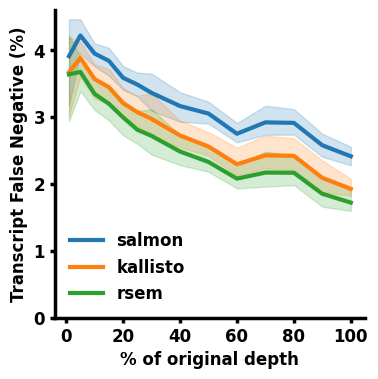

In [48]:
plt.figure(figsize = (4,4))


ax = sns.lineplot(data = fns, x = 'per', y = 'percent_fn', hue = 'method', lw = 3)



for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(width = 2.5)

plt.xticks(size = 12, weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.ylim(bottom = 0)


legend = plt.legend(frameon=False, prop={'weight':'bold', 'size':12},loc='lower left',)
for line in legend.get_lines():
    line.set_linewidth(3)



plt.xlabel('% of original depth', size = 12, weight = 'bold')
plt.ylabel('Transcript False Negative (%)', size = 12, weight = 'bold')


plt.savefig('figures/tx_fn_line.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_fn_line.svg', bbox_inches = 'tight')

plt.show()

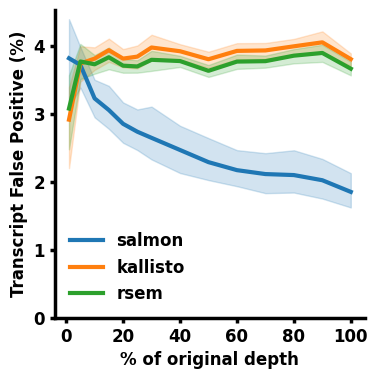

In [49]:
plt.figure(figsize = (4,4))

ax = sns.lineplot(data = fps, x = 'per', y = 'percent_fp', hue = 'method', lw = 3)


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(width = 2.5)

plt.xticks(size = 12, weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.ylim(bottom = 0)


legend = plt.legend(frameon=False, prop={'weight':'bold', 'size':12})
for line in legend.get_lines():
    line.set_linewidth(3)



plt.xlabel('% of original depth', size = 12, weight = 'bold')
plt.ylabel('Transcript False Positive (%)', size = 12, weight = 'bold')

plt.savefig('figures/tx_fp_line.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_fp_line.svg', bbox_inches = 'tight')



plt.show()

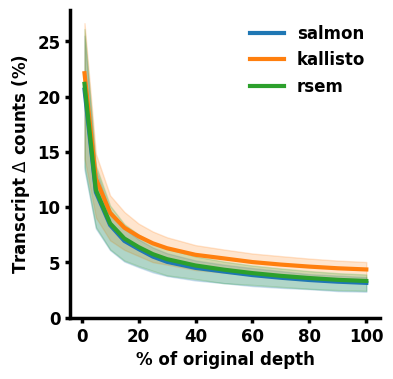

In [50]:
plt.figure(figsize = (4,4))


ax = sns.lineplot(data = misassigned, x = 'per', y = 'percent_misassigned', hue = 'method', lw = 3)



for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(width = 2.5)

plt.xticks(size = 12, weight = 'bold')
plt.yticks(size = 12, weight = 'bold')


plt.ylim(bottom = 0)


legend = plt.legend(frameon=False, prop={'weight':'bold', 'size':12})
for line in legend.get_lines():
    line.set_linewidth(3)



plt.xlabel('% of original depth', size = 12, weight = 'bold')
plt.ylabel(r'Transcript $\Delta$ counts (%)', size = 12, weight = 'bold')


plt.savefig('figures/tx_delta_line.png', dpi = 300,bbox_inches = 'tight')
plt.savefig('figures/tx_delta_line.svg', bbox_inches = 'tight')



plt.show()